# Neuroscience 490
## Lesson 4 - Exploratory Data Analysis
### Content
[Section 1 - Loading and Cleaning Data](#Section1)
<br/>
[Section 2 - Peak Detection and Spike Sorting](#Section2)
<br/>
[Section 3 - Ensemble Averaging Example](#Section3)
<br/>
<br/><br/><br/>
In this lesson, we are going to begin talking about exploratory data analysis (EDA) and the specifics of how to work with the data you collect in lab. EDA is exactly what it sounds like and essentially consists of us loading our data and plotting it in different ways to identify its contaents and main characteristics.

<a id='Section1'></a>
### Section 1 - Loading and Cleaning Data

Like always we begin by importing the libraries that we will need. The first of these you alredy know, <code>numpy</code> and <code>matplotlib</code>, but we will also use some functionality in the scientific computing library <code>scipy</code>. Scipy is an incredibly powerful library which we will only shallowly explore in this class. We also are going to import a <code>LabChartDataset</code> object that we specifically designed for this course.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from labchart_dataset import LabChartDataset
plt.rcParams['figure.dpi'] = 200

In [2]:
# We must export our data as a MATLAB file in order for LabChartDataset to work
file_path = '/Users/jeremyschroeter/Desktop/School_Work/UW/Neuro301-Coding-Kit/Data/spontaneous.mat'
dataset = LabChartDataset(file_path)

The <code>dataset</code> variable refers to our custom <code>LabChartDataset</code> object which has some easy methods to access our data. We can easily access each block in our Lab Chart data by using the <code>get_block()</code> method. This method will return to us a numpy array with our data. If we have a single channel this numpy array will be 1D and have length equal to the timepoints in that block. If we have multiple channels it will be of size (channels, timepoints).  If we only have a single block in our data we can just pass <code>0</code> as the <code>block_index</code> and get the whole recording. In this example, we only did 1 recording of some spontaneous activity in a cockroach leg.

In [3]:
block = dataset.get_block(0)
print(block)

[-0.00070527 -0.00070527 -0.00076777 ...  0.00041797  0.00073047
  0.00098047]


We can also access the sample rate for each channel by looking at the <code>sample_rate</code> property

In [4]:
print(f'Sample rate of our recording is {dataset.sample_rate}')

Sample rate of our recording is [[20000.]]


Okay, lets actually take a look at our data. Our variable <code>block</code> is a numpy array, so we can just call <code>plt.plot()</code> to look at our data.

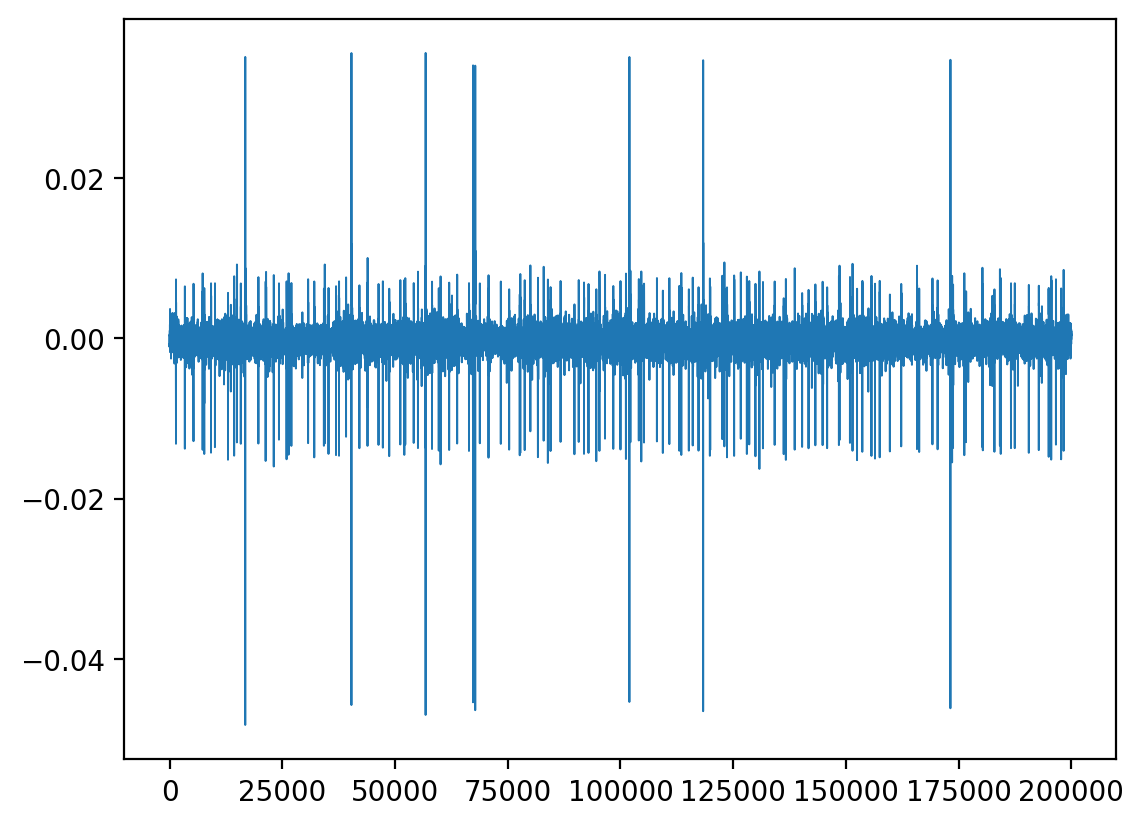

In [5]:
plt.plot(block, lw=0.7)
plt.show()

Excellent! We are now looking at the data we collected in LabChart. Onr of the first things we can notice in this plot is that the ticks on the x-axis are referring to the sample number, *not* the time point. This was a 10 second recording at 20kHz, hence the final x-tick begin 200000. Something in our actual data we can notice is the large disparity in spike heights and timing. Given that this is an extracellular recording, these are likely two different neurons that happened to be close to our probe while recording. One natural question you might ask is how can I extract information about these two distinct neurons? Maybe you want to see how their AP waveforms differ, or what their width is. This sort of neuron identification procedure is called *spike sorting*. There are highly sophisticated algorithms for performing spike sorting on data, but for this class we are going to go over a simple general purpose method that is identical to what you would do in LabChart.
</br></br>
### Section 2 - Peak Detection and Spike Sorting
For our spike sorting, we are going to use the <code>find_peaks</code> function from the <code>scipy.signal</code> module. In this notebook we will go over the basics, but when working on your lab reports you may find it necesarry to use [the function documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html). To use the function you can call <code>scipy.signal.find_peaks()</code> on your data. We have already imported <code>scipy.signal</code> for you, so you can just write <code>signal.find_peaks()</code>.</br></br>

In [6]:
peaks = signal.find_peaks(x=block)
print(peaks)
peaks = peaks[0]

(array([     9,     13,     17, ..., 199976, 199988, 199993]), {})


When we call <code>signal.find_peaks()</code> and only pass it our data, python returns to us an array containing the positions of all the peaks that it found and an empty dictionary. Dictionaries are a Python object that we haven't yet gone over, but essentially they are used to contain objects which have a relationship with a label. For our purposes dictionaries are objects that we can index with strings to get objects that those strings describe. We can access the objects/values contained in a dictionary with the following syntax: <code>object_of_interest = dict_name['label']</code>
</br></br>
The dictionary returned to use by <code>find_peaks()</code> will be populated with details about the peaks if we provide some more information in our function call. One very helpful way of visualizing peaks is by plotting their width against their height. This is the same as the discriminator view which you have used in LabChart. In order to get that information however, we need to have the dictionary be populated with the properties of the peaks, and we also need to invert our data because this is an extracellular recording and action potentials appear as a spike in the wrong direction. To invert our data we can simply multiply by -1, but we will need to change it back later for plotting.</br></br>

Take a second to read the documentation linked above and see if you can figure out how to get the properties dictionary to not be empty before continuining.

In [7]:
inverted_data = block * -1

peaks, properties = signal.find_peaks(inverted_data, height=(None, None), width=(None, None))
print(peaks)

# To see what labels a dictionary contains we can use the keys() method
print(properties.keys())

[     7     12     15 ... 199982 199991 199996]
dict_keys(['peak_heights', 'prominences', 'left_bases', 'right_bases', 'widths', 'width_heights', 'left_ips', 'right_ips'])


In [8]:
heights, widths = properties['peak_heights'], properties['widths']

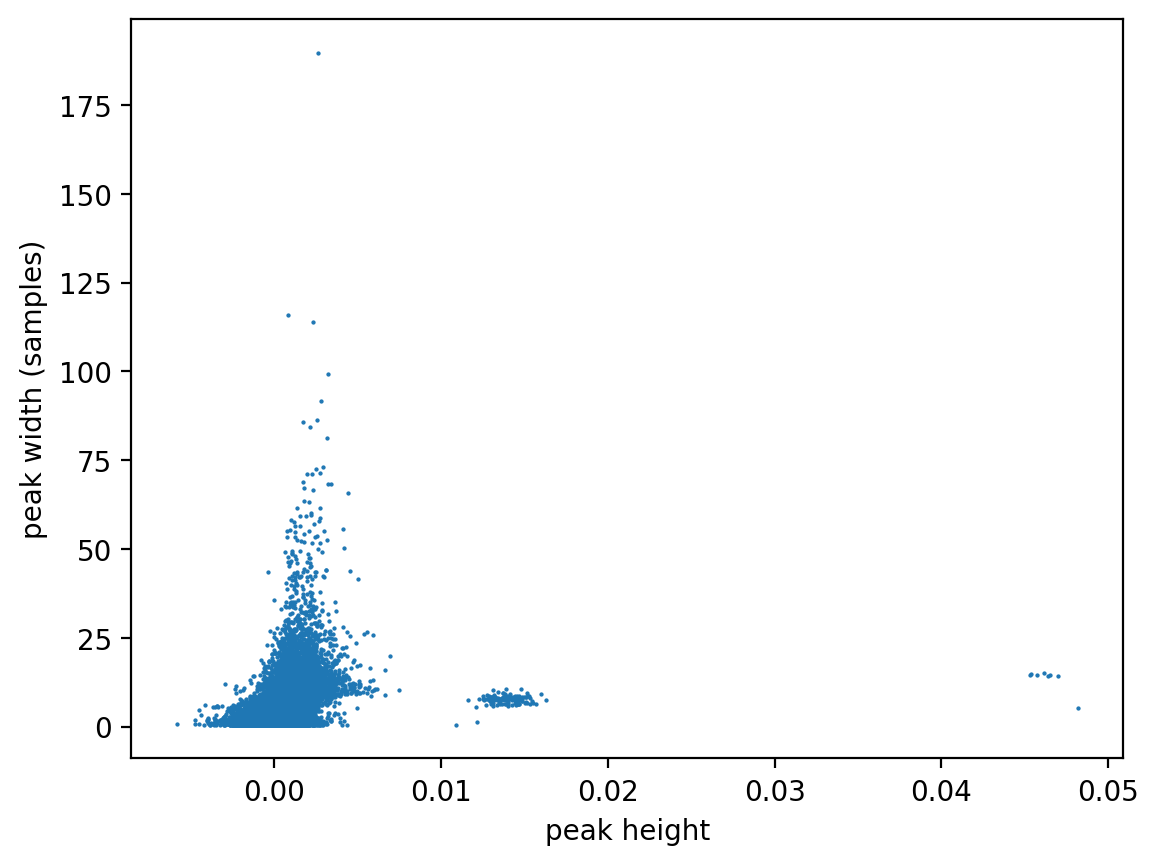

In [9]:
plt.scatter(heights, widths, s=0.3)
plt.xlabel('peak height')
plt.ylabel('peak width (samples)')
plt.show()

Great! This is exactly the view we would see with the discriminator view in LabChart. Most of the points in the bottom left are simply random fluctuations. Ignoring the large population of points in the bottom left, we can clearly see two clusters, one with a peak height $\approx$ .015 and another with a peak height $\approx$ .046. Lets use numpys boolean indexing capabilities to extract the two clusters.</br></br>
To do this we'll create two "masks". Masks are basically an application of boolean indexing on arrays. For example we can use masks to index the peak indices variable for just those peaks where the heights are in a certain range. Let's do this for the first cluster, where the peak heights lie between 0.01 and 0.02

In [10]:
cluster_one_mask = (heights > 0.01) & (heights < 0.02)
cluster_one_peaks = peaks[cluster_one_mask]
print(cluster_one_mask)
print(cluster_one_peaks)

[False False False ... False False False]
[  1429   3395   5315   7339   7700   9197  10071  12962  14328  14943
  15802  19702  21313  21401  23114  24268  25956  26397  27018  30728
  32093  34232  34419  35255  36920  37587  39148  42103  43905  43924
  46347  47306  48717  51178  52066  52274  54151  55094  56721  58210
  59705  60106  62011  63786  66408  68813  70739  73464  75317  77667
  77787  78765  80017  81702  82971  83905  84494  86718  89793  90745
  91919  92913  94641  95341  96576  98409 100004 101217 102202 104071
 104620 105228 108087 109401 110840 113051 113493 115165 116029 117315
 118331 119832 119906 122576 123045 123631 125209 126687 128035 128559
 129941 130813 131603 134200 136204 136684 138642 140289 141715 143224
 144834 145835 148449 148580 150896 151466 152470 153637 155666 156455
 157494 159748 162264 165763 166249 169192 170336 173166 173552 173760
 176257 176641 180272 180363 182937 184152 184338 186613 187450 190563
 192779 194975 195530 196581 197730

<code>cluster_one_mask</code> is an array the same length as <code>heights</code> but filled with either <code>True</code> or <code>False</code> depending on if the element at that position in <code>heights</code> meets the mask criteria. We can then use that array to extract specific values from another array so long as they are the same length. Since our peak indices stored in <code>peaks</code> correlates 1-to-1 with out values in <code>heights</code>, following this procedure gets us the peak indices with the height criteria we specified!</br></br>
If any of that doesn't make sense, please review and reach out if you still don't get it! This will come up again!</br></br>

Now that we have filtered our peaks for just the ones we are interested in, lets use the indices to visualize the waveforms we recorded. Since the positions contained in <code>cluster_one_peaks</code> are when the peak actually occurs, this means we will have to take a slice from a few samples before the peak to a few samples afterwards.

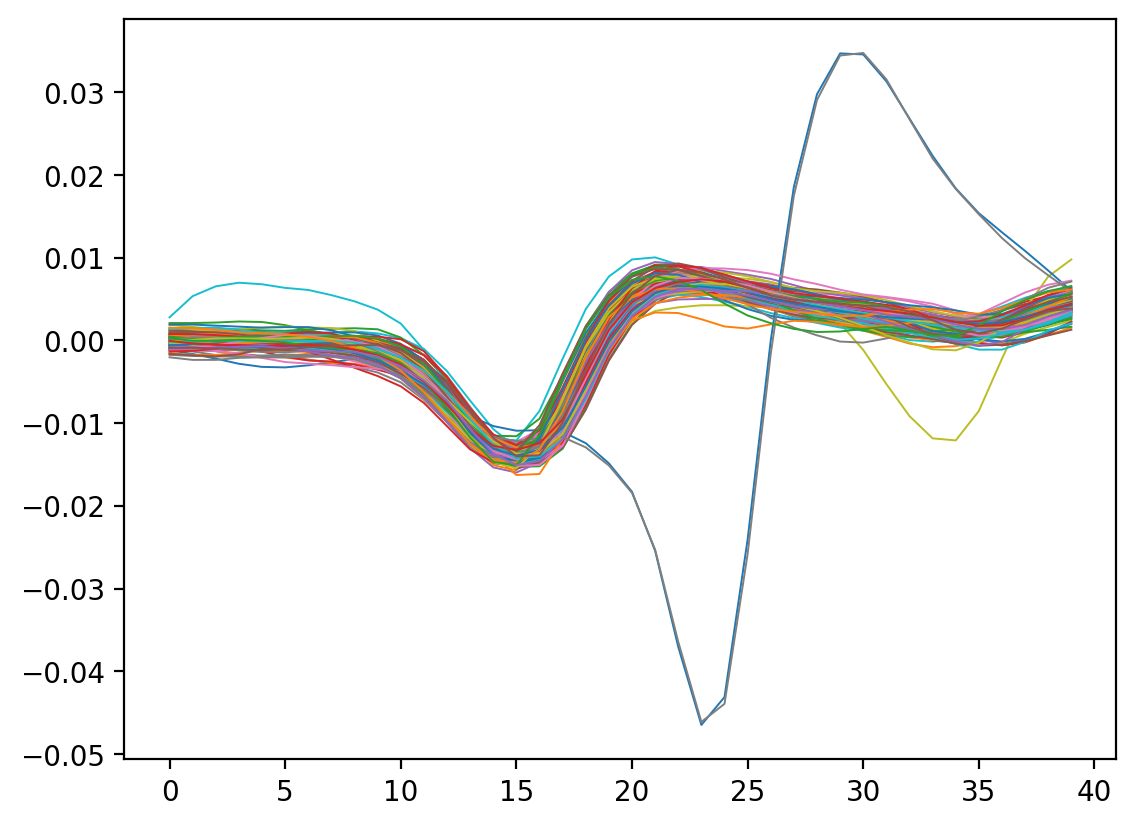

In [11]:
for spike in cluster_one_peaks:
    plt.plot(-1 * inverted_data[spike - 15:spike + 25], lw=0.7)
plt.show()

Hmmmm....this looks wrong. We filtered our peak heights for those less than 0.02 but we got one that is clearly much higher? Why is that?

The problem is that we didn't specify a minimum distance between peaks. If you look at the peaks that seem outside of the range we want, you can see that there is a small hump between the larger spike. To fix this lets pass specify a minimum peak distance of 15 samples.

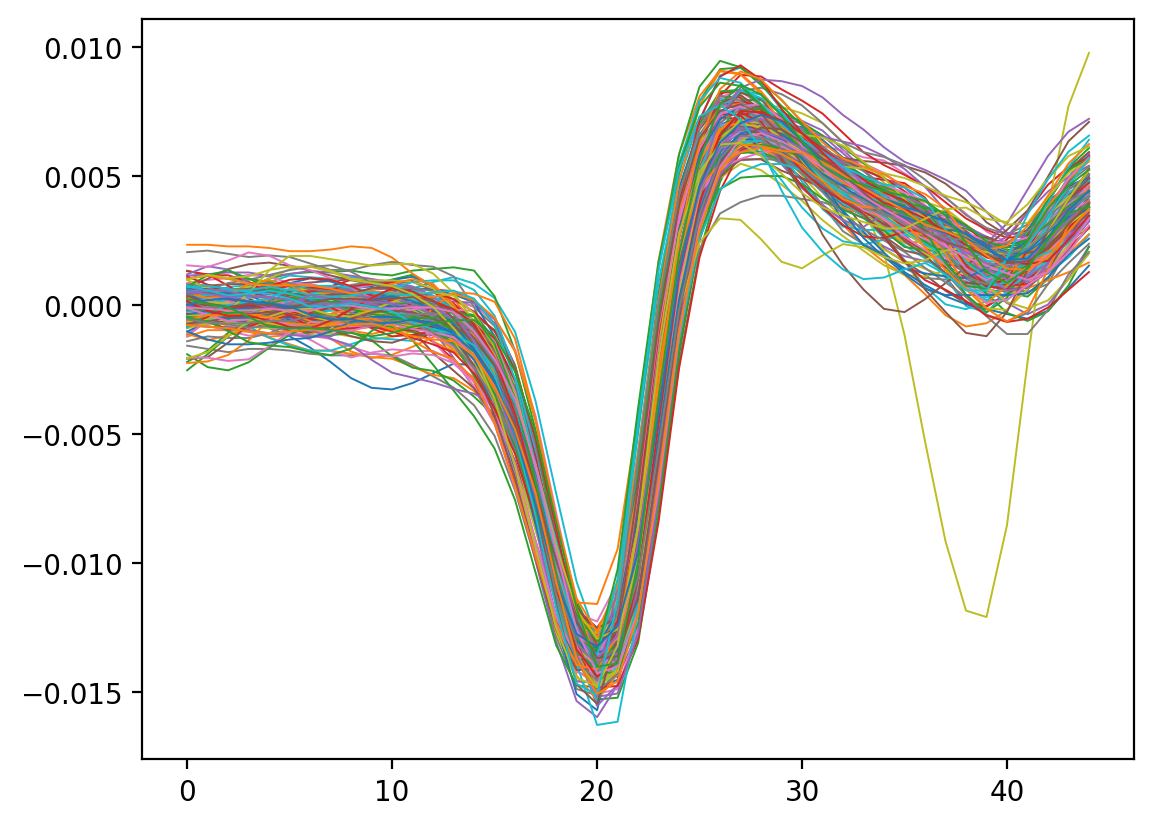

In [12]:
peaks, properties = signal.find_peaks(inverted_data, height=(None, None), width=(None, None), distance=35)
heights, widths = properties['peak_heights'], properties['widths']
cluster_one_mask = (heights > 0.01) & (heights < 0.02)
cluster_one_peaks = peaks[cluster_one_mask]

for spike in cluster_one_peaks:
    plt.plot(block[spike - 20:spike + 25], lw=0.7)
plt.show()

Nice! This is looking much better, even though we still have that one spike that happened very close to one another. All of these llines overlaid ontop of one another is too much to look at. Lets instead find what the average spike for this neuron looks like. To do this we can initialize an array of shape (N, 30) where N is the number of spikes and 30 is the number of samples. We'll then populate the rows with the traces and then average across the first dimension.

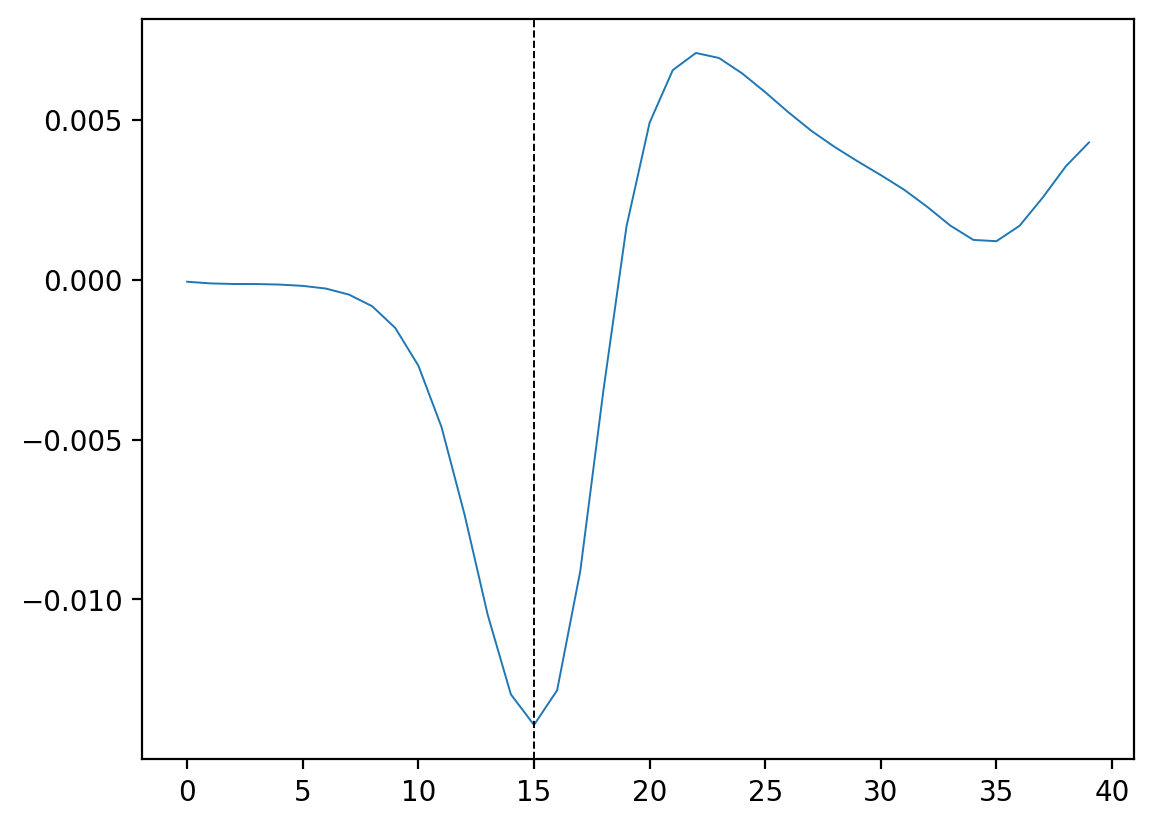

In [13]:
n_peaks = cluster_one_peaks.shape[0]
spikes = np.zeros(shape=(n_peaks, 40))
for i, peak in enumerate(cluster_one_peaks):
    spike = block[peak - 15:peak + 25]
    spikes[i] = spike
average_spike_one = spikes.mean(axis=0)
plt.plot(average_spike_one, lw=0.7)
plt.axvline(x=15, linestyle='--', lw=0.7, c='black')
plt.show()

Fantastic. Now lets add some labels, and to be rigorous lets add shade the region one standard deviation above and below the average to indicate our uncertainty about the peak waveform. To do this we can a matplotlib function <code>plt.fill_between()</code>

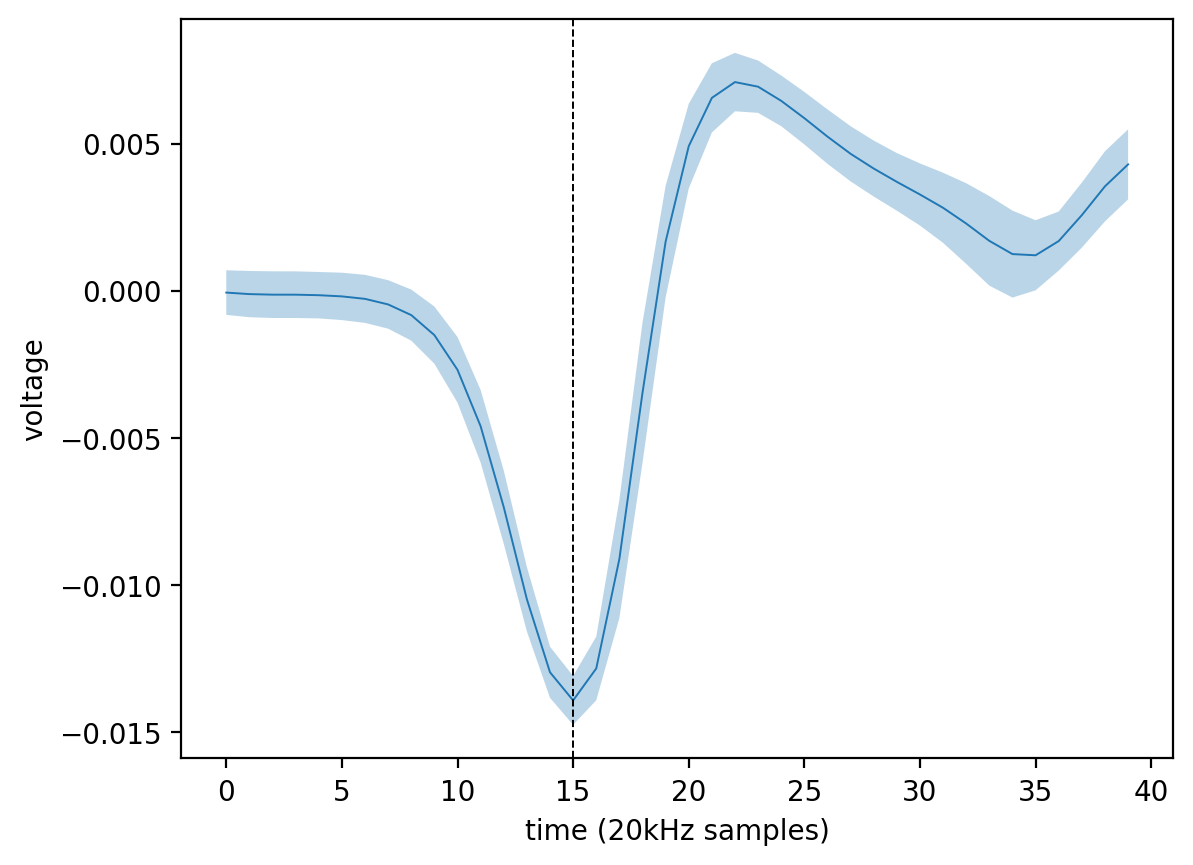

In [14]:
spike_sd_one = spikes.std(axis=0)
plt.plot(average_spike_one, lw=0.7)
plt.axvline(x=15, linestyle='--', lw=0.7, c='black')
plt.fill_between(x=np.arange(40),
                 y1=average_spike_one + spike_sd_one,
                 y2=average_spike_one - spike_sd_one,
                 alpha=0.3)
plt.xlabel('time (20kHz samples)')
plt.ylabel('voltage')
plt.show()

### Section 3 - Ensemble Averaging Example
Great, now lets do the same for our other neuron and walk through the process of making a lab report level figure.

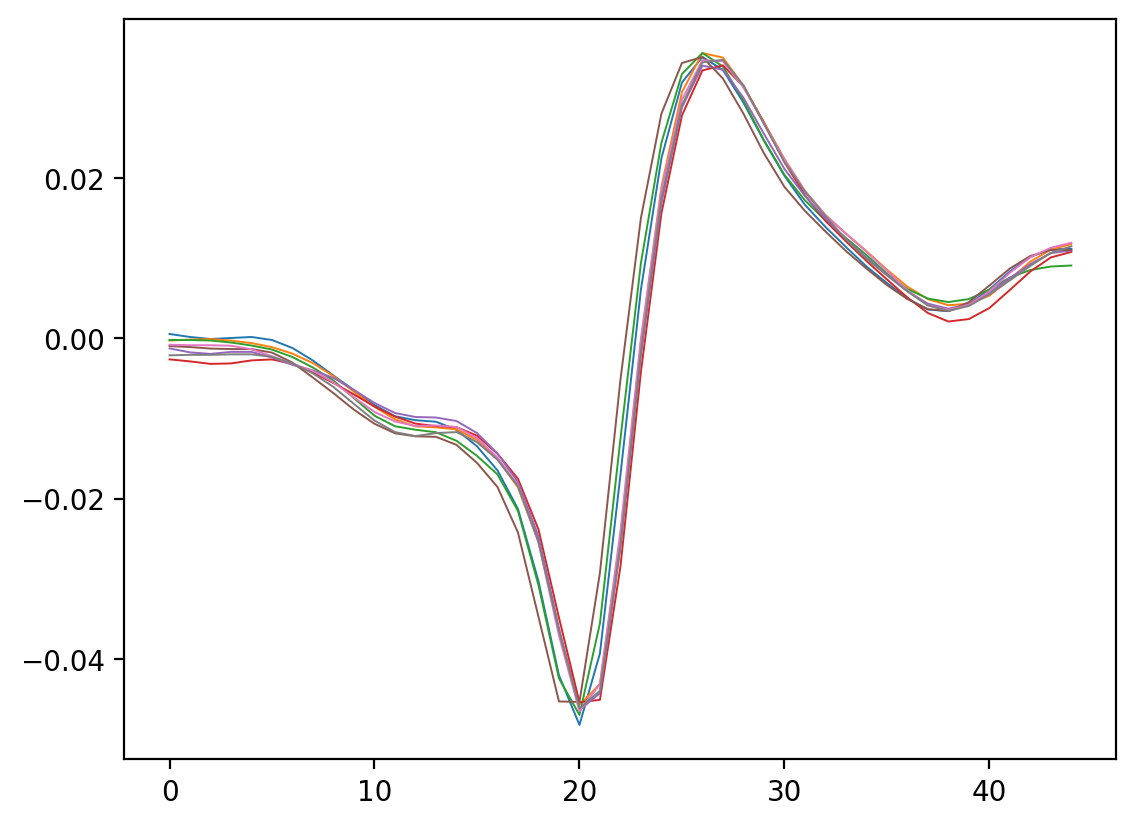

In [15]:
cluster_two_mask = (heights > 0.02)
cluster_two_peaks = peaks[cluster_two_mask]

for spike in cluster_two_peaks:
    plt.plot(block[spike - 20:spike + 25], lw=0.7)
plt.show()

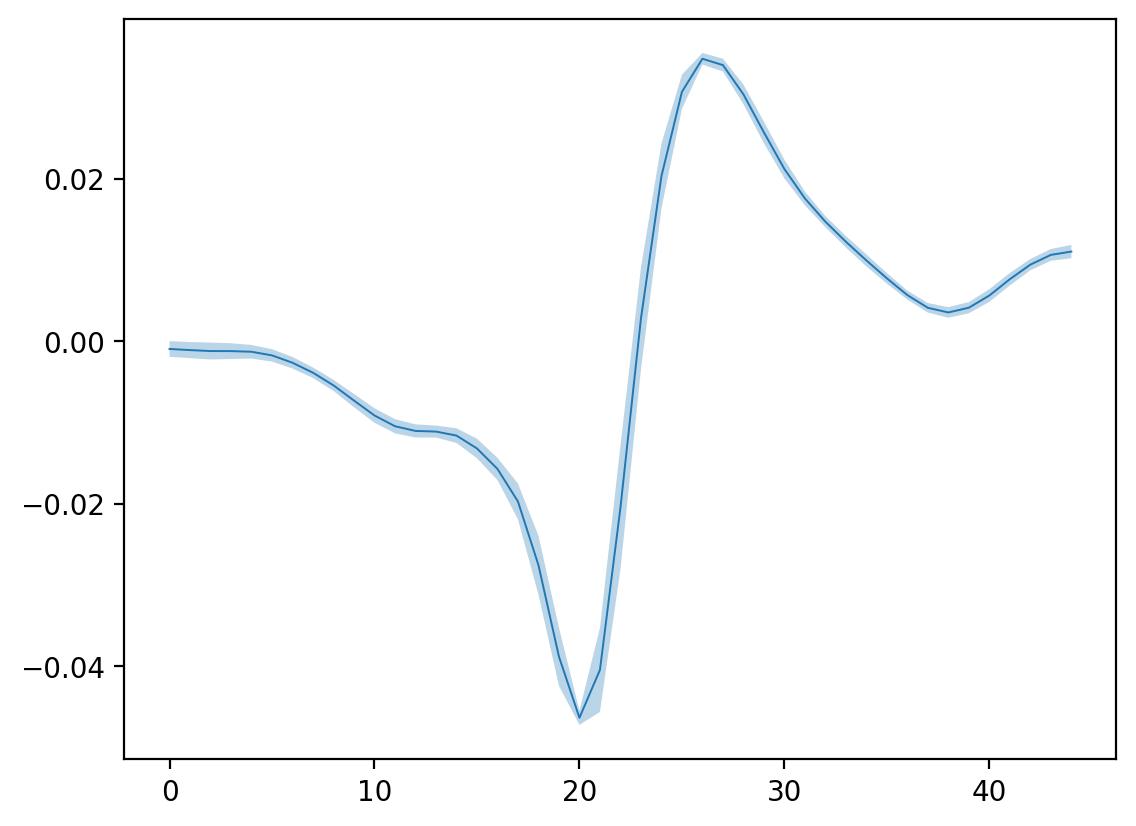

In [16]:
n_peaks = cluster_two_peaks.shape[0]
spikes = np.zeros(shape=(n_peaks, 45))
for i, peak in enumerate(cluster_two_peaks):
    spike = block[peak - 20:peak + 25]
    spikes[i] = spike
average_spike_two = spikes.mean(axis=0)
spike_sd_two = spikes.std(axis=0)
plt.plot(average_spike_two, lw=0.7)
plt.fill_between(x = np.arange(45),
                 y1 = average_spike_two - spike_sd_two,
                 y2 = average_spike_two + spike_sd_two,
                 alpha=0.3)

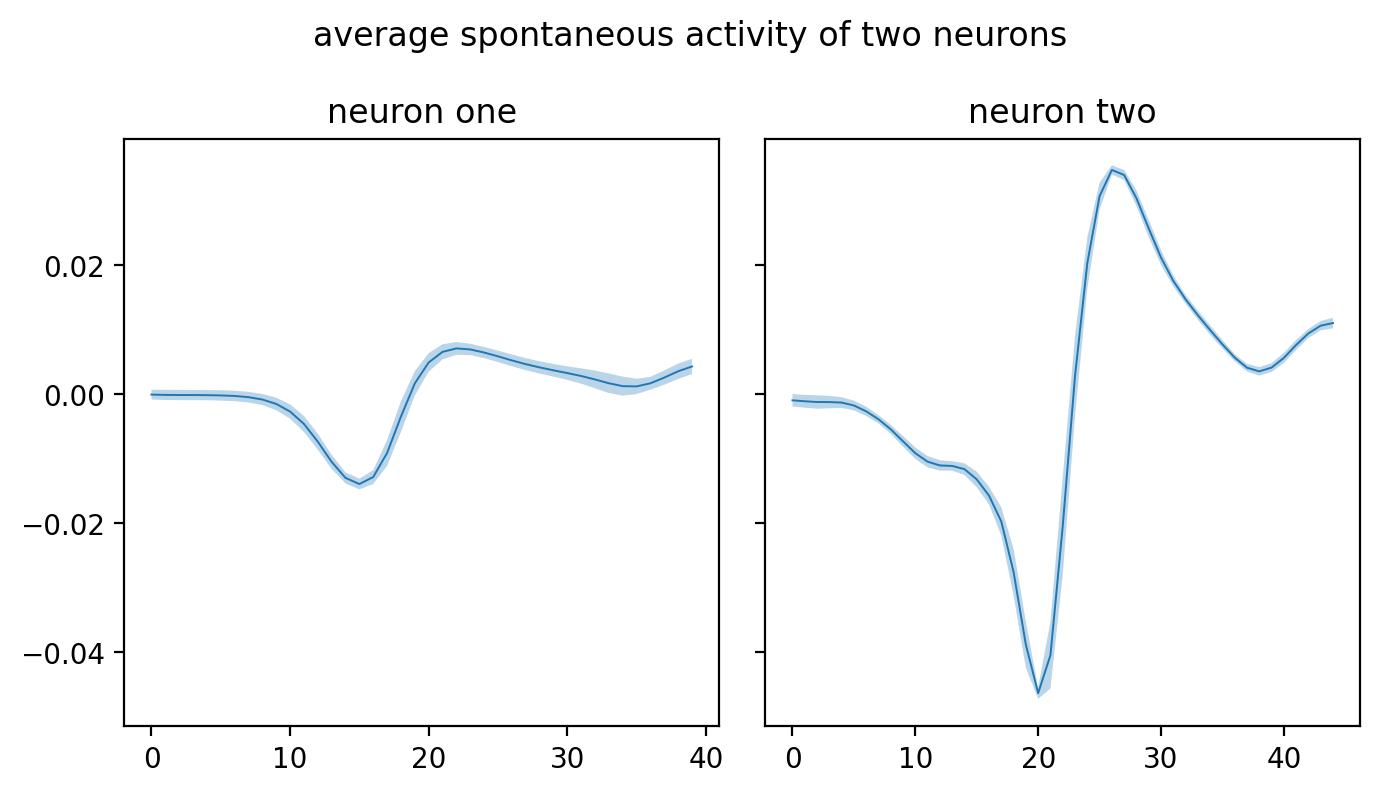

In [17]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(7, 4))


ax[0].plot(average_spike_one, lw=0.7)
ax[0].fill_between(x = np.arange(40),
                   y1 = average_spike_one - spike_sd_one,
                   y2 = average_spike_one + spike_sd_one,
                   alpha=0.3)
ax[0].set_title('neuron one')

ax[1].plot(average_spike_two, lw=0.7)
ax[1].fill_between(x = np.arange(45),
                   y1 = average_spike_two - spike_sd_two,
                   y2 = average_spike_two + spike_sd_two,
                   alpha=0.3)
ax[1].set_title('neuron two')
fig.suptitle('average spontaneous activity of two neurons')
fig.tight_layout()
plt.show()
